In [16]:
import os

import matplotlib.pyplot as plt
import numpy as np
from jax import random
from PIL import Image
from splotch import get_input_data, register, run_nuts, savagedickey

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"

Image.MAX_IMAGE_PIXELS = 1000000000

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
splotch_input_data = get_input_data("metadata.tsv", 3)

In [3]:
splotch_input_data.metadata.groupby(
    ["level_1", "level_2", "level_3"], observed=True
).size().reset_index(name="num_spots").head()

,level_1,level_2,level_3,num_spots
0,G93A p120,F,1394,427
1,G93A p120,M,975,573
2,WT p120,F,1040,440
3,WT p120,M,1310,464
4,WT p120,M,2967,570


In [4]:
splotch_input_data.metadata.groupby(
    ["level_1", "level_2", "level_3", "aar"], observed=True
).size().reset_index(name="num_spots").head()

,level_1,level_2,level_3,aar,num_spots
0,G93A p120,F,1394,Cent_Can,37
1,G93A p120,F,1394,Dors_Edge,22
2,G93A p120,F,1394,Dors_Horn,42
3,G93A p120,F,1394,Dors_Med_White,32
4,G93A p120,F,1394,Lat_Edge,13


In [5]:
key = random.PRNGKey(0)

res = run_nuts(key, 3660, splotch_input_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

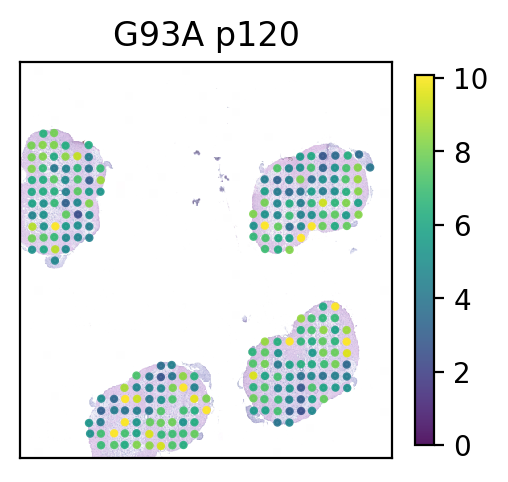

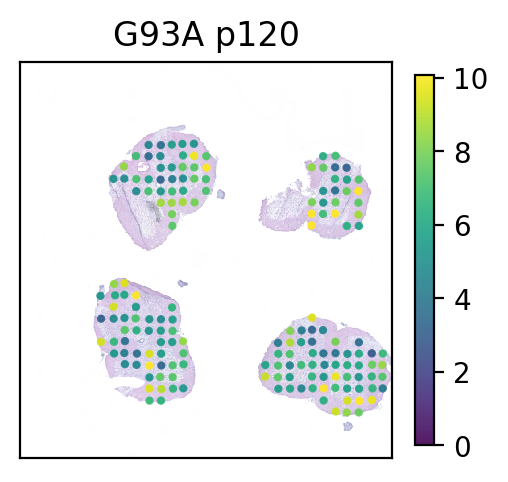

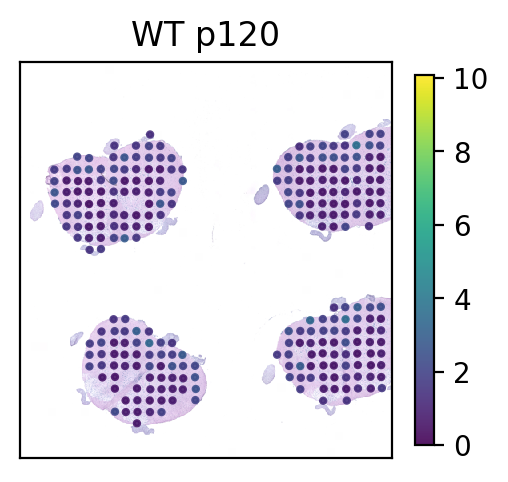

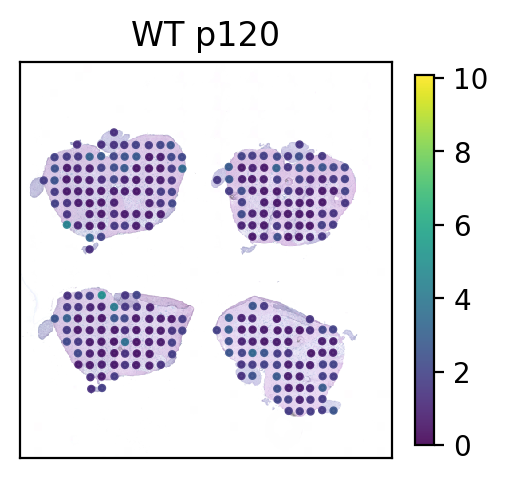

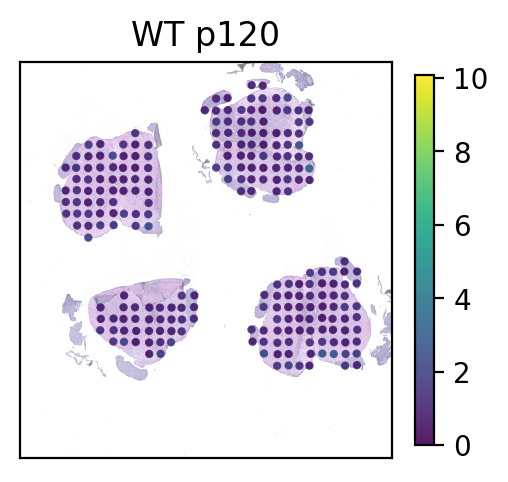

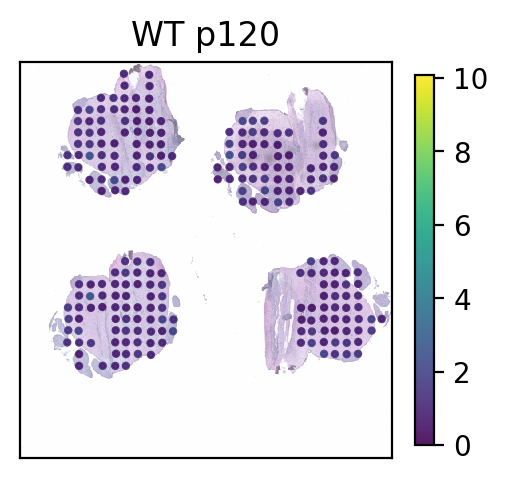

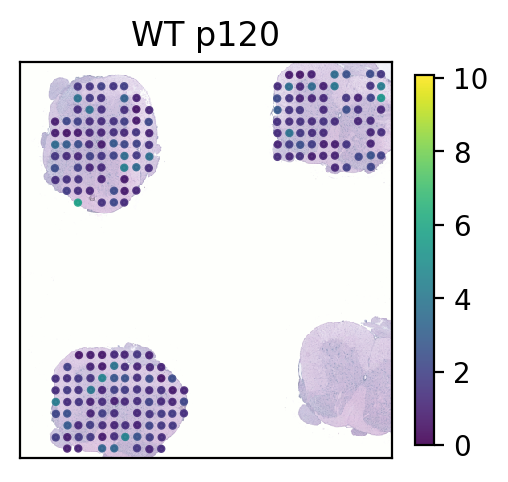

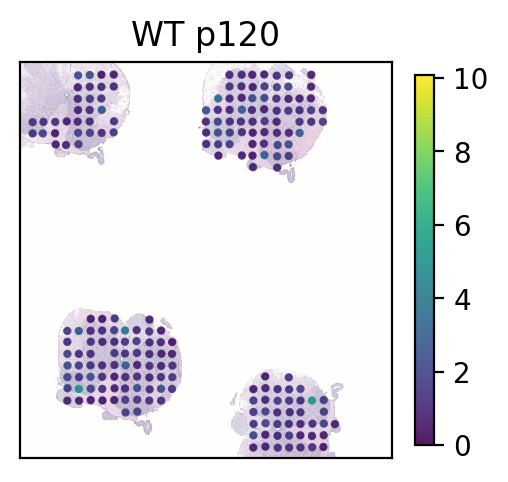

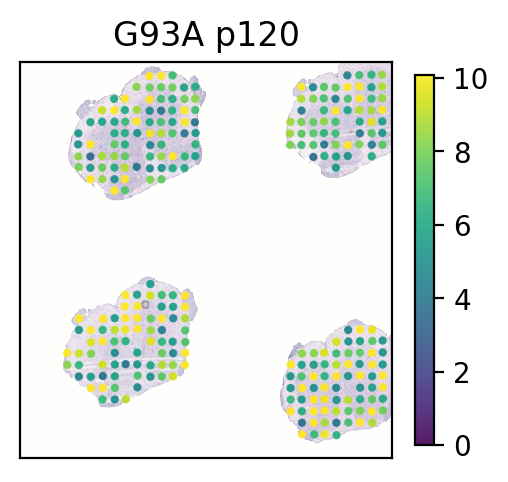

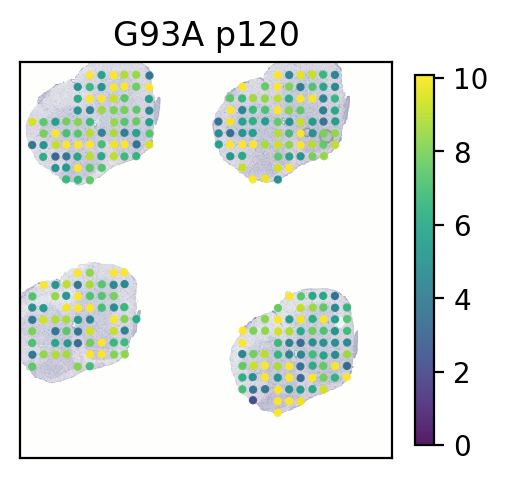

In [6]:
rates_s = res.rates().mean(1)
vmin, vmax = 0, np.percentile(rates_s, 95)

for count_file in res.metadata.index.get_level_values("count_file").unique():
    fig = plt.figure()
    fig.set_size_inches(3, 3)

    ax = fig.add_subplot(1, 1, 1)

    tissue_image = Image.open(
        res.metadata.query("count_file == @count_file").image_file.iloc[0]
    )

    xdim, ydim = tissue_image.size

    # downsample the image
    tissue_image = tissue_image.resize(
        (np.round(xdim * 0.05).astype(int), np.round(ydim * 0.05).astype(int))
    )

    xdim, ydim = tissue_image.size
    pixel_dim = 194.0 / (6200.0 / xdim)

    x = pixel_dim * (res.metadata.query("count_file == @count_file").x - 1)
    y = pixel_dim * (res.metadata.query("count_file == @count_file").y - 1)
    c = rates_s[count_file]

    ax.imshow(tissue_image, origin="upper", interpolation="none", alpha=0.6)

    cb = ax.scatter(
        x, y, s=4, c=c, cmap="viridis", vmin=vmin, vmax=vmax, marker="o", alpha=0.9
    )

    ax.set_aspect("equal")

    ax.set_xticks([])
    ax.set_yticks([])

    # # put some information on the array in the title
    ax.set_title(f"{res.metadata.query('count_file == @count_file').level_1.iloc[0]}")

    cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
    # cbar.set_label(r'%s $\bar{\lambda}$'%(gene))

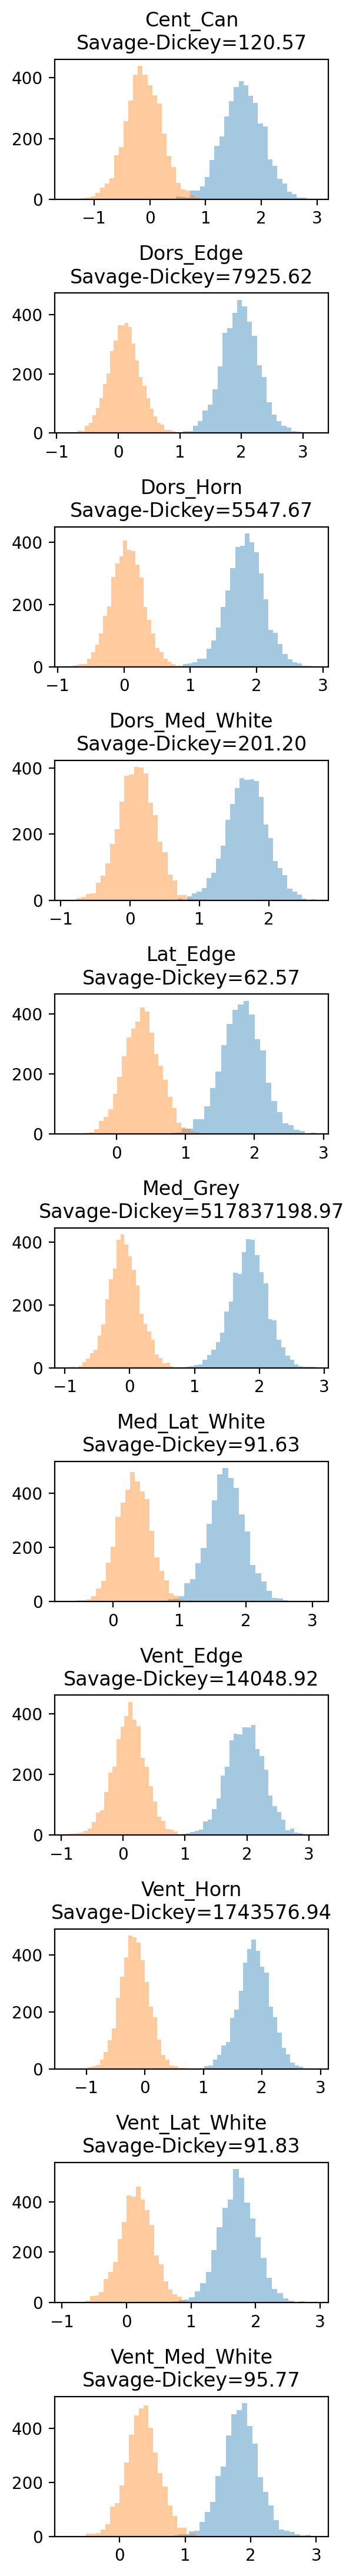

In [21]:
fig = plt.figure()

aars = splotch_input_data.aars()

fig.set_size_inches(3, 2 * len(aars))

for aar_idx in range(len(aars)):
    ax = fig.add_subplot(len(aars), 1, aar_idx + 1)
    savage_dickey_density_ratio = savagedickey(
        res.posterior_samples["beta_level_1"][:, 0, aar_idx],
        res.posterior_samples["beta_level_1"][:, 1, aar_idx],
    )
    ax.set_title(f"{aars[aar_idx]}\nSavage-Dickey={savage_dickey_density_ratio:.2f}")
    ax.hist(res.posterior_samples["beta_level_1"][:, 0, aar_idx], 30, alpha=0.4)
    ax.hist(res.posterior_samples["beta_level_1"][:, 1, aar_idx], 30, alpha=0.4)

fig.set_tight_layout(True)

In [9]:
key = random.PRNGKey(0)
register(key, splotch_input_data, num_steps=10_000)

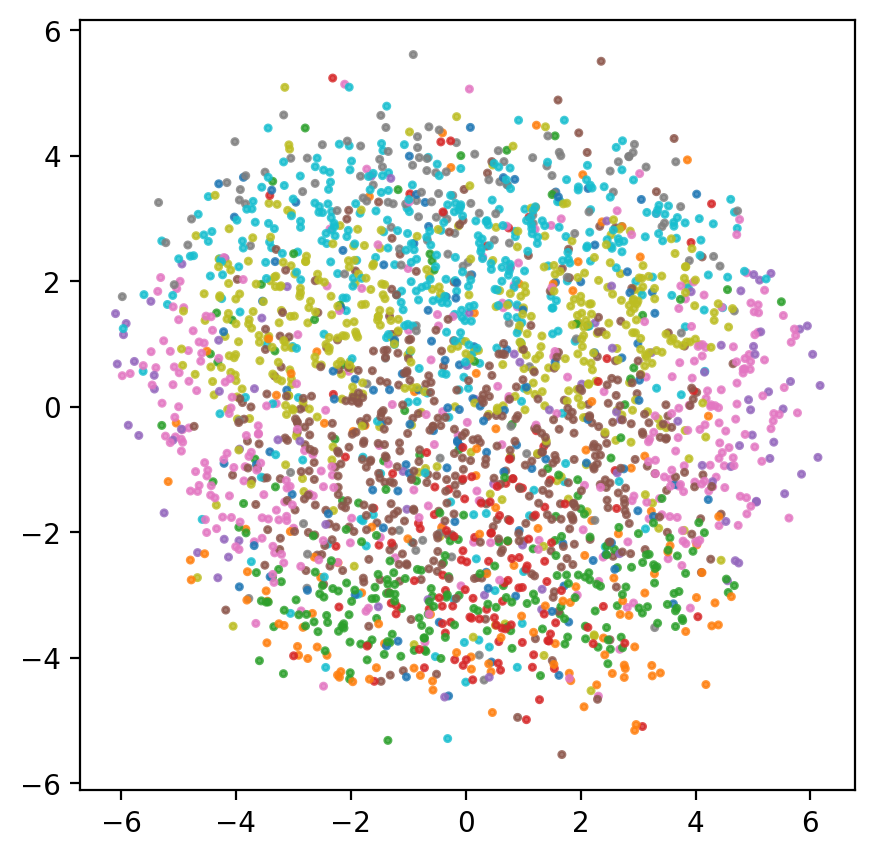

In [10]:
fig = plt.figure()
fig.set_size_inches(5, 5)

ax = fig.add_subplot(1, 1, 1)

ax.scatter(
    splotch_input_data.metadata.x_registration,
    splotch_input_data.metadata.y_registration,
    c=splotch_input_data.annotations(),
    cmap="tab10",
    s=5,
    alpha=0.8,
)

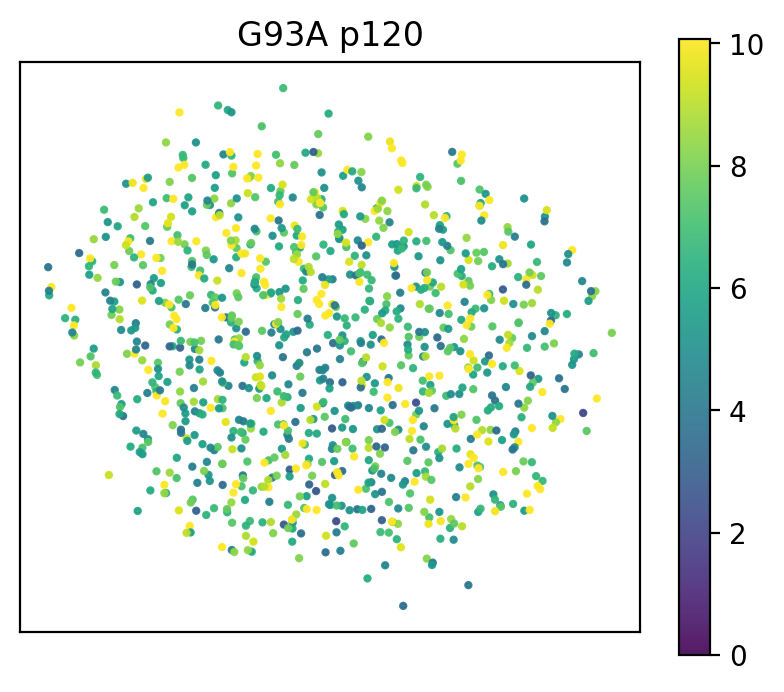

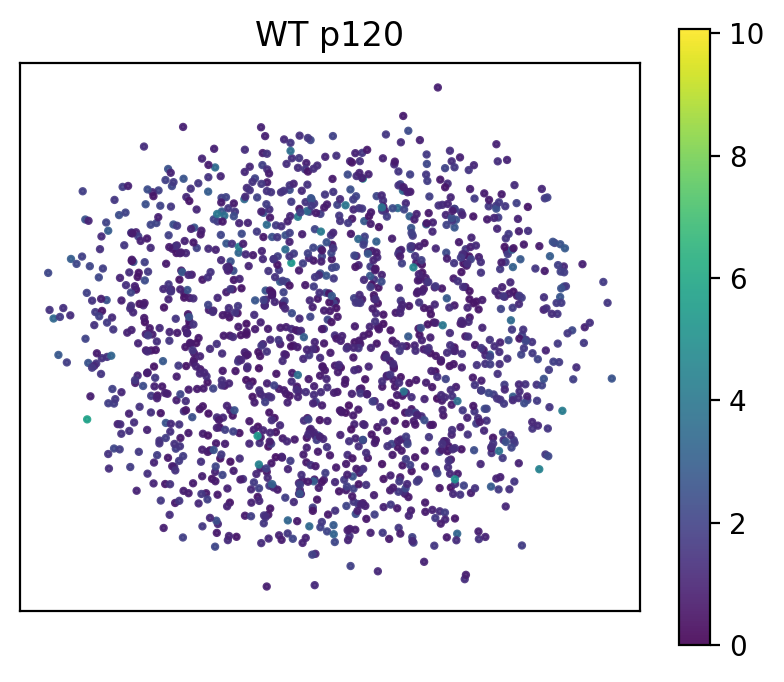

In [11]:
rates_s = res.rates().mean(1)
vmin, vmax = 0, np.percentile(rates_s, 95)

for level_1_category in res.metadata.level_1.unique():
    fig = plt.figure()
    fig.set_size_inches(5, 5)

    ax = fig.add_subplot(1, 1, 1)

    tissue_image = Image.open(
        res.metadata.query("count_file == @count_file").image_file.iloc[0]
    )

    x = splotch_input_data.metadata.query("level_1 == @level_1_category").x_registration
    y = splotch_input_data.metadata.query("level_1 == @level_1_category").y_registration
    c = rates_s[splotch_input_data.metadata.query("level_1 == @level_1_category").index]

    cb = ax.scatter(
        x, y, s=4, c=c, cmap="viridis", vmin=vmin, vmax=vmax, marker="o", alpha=0.9
    )

    ax.set_aspect("equal")

    ax.set_xticks([])
    ax.set_yticks([])

    # # put some information on the array in the title
    ax.set_title(f"{level_1_category}")

    cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
    # cbar.set_label(r'%s $\bar{\lambda}$'%(gene))